Example of the process of doing DEMs for all orbits for a given observation of an AR – where we don't window out any intervals because of shifts, etc. Instead, we will save energy-specific information about the percent of NuSTAR emission in the chosen region as a function of time, for later inspection. This will help identify cases where pointing shifts might cause unphysical distortion to the DEM inputs. 

Note: auto-download of an AIA file (for use in the initial co-alignmnet) will break while the JSOC is still down. We will add a thing where you can point to an existing AIA file instead.

Overview:

- Define orbits
- Run time interval selection
- Examine resulting intervals
- Manually establish a co-alignment shift between NuSTAR and AIA
- Automatically find co-alignment shifts + make regions for all other time intervals (note: this relies on the assumption that the COM is a good representation of the location of the brightest source, i.e. that the NuSTAR data is primarially one blob).
- Save AIA region files for NCCS input
- NOT IN THIS NOTEBOOK: YOU THEN TAKE THOSE AND MAKE AIA INPUTS ON THE NCCS
- Conduct AIA/NuSTAR DEMs as a function of time, given all the above
- Plot results.
- Print some stats about "left out" times.

In [1]:
# import matplotlib.pyplot as plt
# import numpy as np
# import glob
# from astropy.io import fits
# from astropy import units as u
# import importlib
# import pathlib

#Path to top-level do-dem directory - edit for your system.
path_to_dodem = '/Users/jmdunca2/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')

# #import nustar_dem_prep as nu
import images_and_coalignment as iac
import time_interval_selection as tis
import nustar_utilities as nuutil
import gauss2D as g2d
import nustar_dem_prep as nu


# import os
# # For macOS
# def play_sound():
#     os.system("afplay /System/Library/Sounds/Glass.aiff")

import pickle
import pathlib
import importlib
from astropy import units as u
import numpy as np


In [2]:
key = '11-sep-17'

with open('all_targets.pickle', 'rb') as f:
    data = pickle.load(f)
    
method = data[key]['method']
ARDict = data[key]

id_dirs = ARDict['datapaths']
obsids = ARDict['obsids']
working_dir = ARDict['working_dir']

if method=='double':
    gauss_stats = ARDict['gauss_stats']
    sep_axis = gauss_stats[0][0]
else:
    sep_axis = ''

In [3]:
obsids=[]
for id in id_dirs:
    evt_data, hdr, obsid = nu.return_submap(datapath=id, fpm='A', return_evt_hdr=True, return_obsid=True)
    obsids.append(obsid)
    time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
    timerange = [time0, time1]
    print(timerange[0].strftime('%H-%M-%S'), timerange[1].strftime('%H-%M-%S'))
    

15-55-49 16-55-23
17-32-30 18-32-03
19-09-10 20-08-43
20-45-51 21-36-14


In [6]:
importlib.reload(iac)
aia_dir = '/Users/jmdunca2/sample_aia/sample_aia/'


aiamaps = iac.get_orbit_aiamaps(aia_dir, id_dirs, wave=94)   

/Users/jmdunca2/nustar/sep-2017/80310211001/
2017-09-11 15:55:49
['/Users/jmdunca2/sample_aia/sample_aia/aia.lev1.94A_2017-09-11T155511.14Z.image_lev1.fits']
/Users/jmdunca2/nustar/sep-2017/80310212001/
2017-09-11 17:32:30
['/Users/jmdunca2/sample_aia/sample_aia/aia.lev1.94A_2017-09-11T173211.12Z.image_lev1.fits']
/Users/jmdunca2/nustar/sep-2017/80310213001/
2017-09-11 19:09:09.999999
['/Users/jmdunca2/sample_aia/sample_aia/aia.lev1.94A_2017-09-11T190911.12Z.image_lev1.fits']
/Users/jmdunca2/nustar/sep-2017/80310214001/
2017-09-11 20:45:51
['/Users/jmdunca2/sample_aia/sample_aia/aia.lev1.94A_2017-09-11T204511.14Z.image_lev1.fits']


Goal: write a combined fundtion that, for any number of regions found via any method, plots nustar contours over aia data with all regions shown. 
- In the case of multiple regions (and therefore, multiple different sets of time intervals per orbit), choose the longest time interval for the NuSTAR data.
- In the case where some of the orbits failed TIS for some regions, account for this (only plot sucessful-TIS regions). 

A {'radius': 150.0, 'centerx': <Quantity 1038.80769298 arcsec>, 'centery': <Quantity -156.33799028 arcsec>}
B {'radius': 150.0, 'centerx': <Quantity 1058.63662037 arcsec>, 'centery': <Quantity -162.82969162 arcsec>}


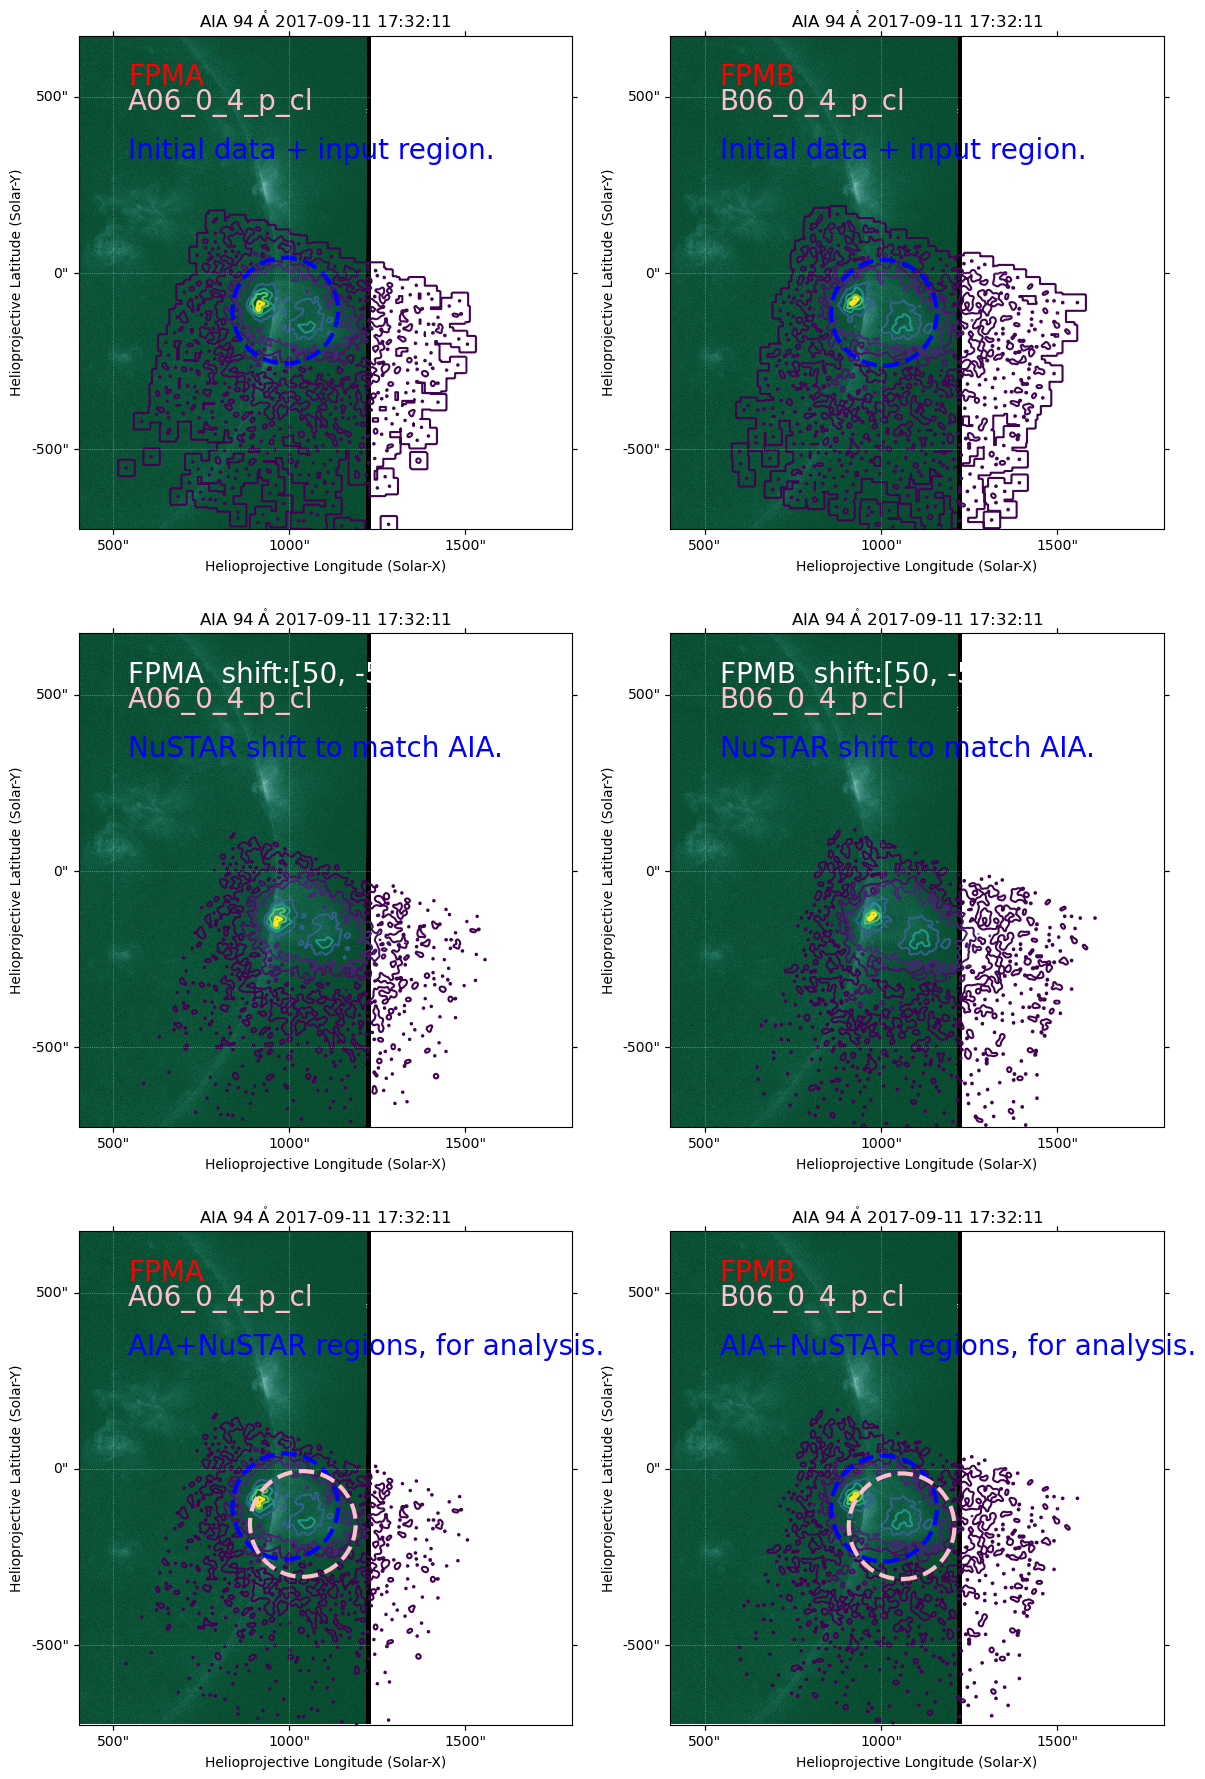

In [11]:
importlib.reload(iac)
aati = iac.per_orbit_region_adjustment(working_dir, id_dirs, obsids, 1, aiamaps, 
                                       nushift=[50, -50], method=method, shush=True, sep_axis=sep_axis)



In [7]:
importlib.reload(iac)

if method in ['input', 'double']:
    if method=='input':
        region_dirs = iac.find_region_dirs(working_dir)
    if method=='double':
        region_dirs = iac.find_direction_dirs(working_dir, sep_axis)

    for r in region_dirs:
        all_time_intervals, all_time_intervals_list = tis.find_all_intervals(r)
        suborbit_dirs = iac.make_all_aia_dicts(all_time_intervals, r, key, additional_path=working_dir)

if method=='fit':
    all_time_intervals, all_time_intervals_list = tis.find_all_intervals(working_dir)
    suborbit_dirs = iac.make_all_aia_dicts(all_time_intervals, working_dir, key)

0 - 0 00-13-00 00-18-50
0 - 1 00-18-50 00-23-00
0 - 2 00-23-00 00-25-10
0 - 3 00-25-10 00-27-00
0 - 4 00-27-00 00-29-05
0 - 5 00-29-05 00-30-10
0 - 6 00-30-10 00-31-05
0 - 7 00-31-05 00-32-00
0 - 8 00-32-00 00-32-50
0 - 9 00-32-50 00-33-45
0 - 10 00-33-45 00-35-00
0 - 11 00-35-00 00-35-55
0 - 12 00-35-55 00-37-10
0 - 13 00-37-10 00-38-30
0 - 14 00-38-30 00-39-35
0 - 15 00-39-35 00-41-10
0 - 16 00-41-10 00-43-25
0 - 17 00-43-25 00-45-20
0 - 18 00-45-20 00-47-50
0 - 19 00-47-50 00-51-30
0 - 20 00-51-30 00-52-45
0 - 21 00-52-45 00-54-25
0 - 22 00-54-25 00-55-50
0 - 23 00-55-50 00-57-15
0 - 24 00-57-15 01-00-15
0 - 25 01-00-15 01-02-15
0 - 26 01-02-15 01-03-30
0 - 27 01-03-30 01-04-45
0 - 28 01-04-45 01-05-40
0 - 29 01-05-40 01-06-40
0 - 30 01-06-40 01-07-50
0 - 31 01-07-50 01-08-55
0 - 32 01-08-55 01-09-45
0 - 33 01-09-45 01-10-20
0 - 34 01-10-20 01-11-20
0 - 35 01-11-20 01-12-00
0 - 36 01-12-00 01-12-45
0 - 37 01-12-45 01-13-25

0 - 0 00-13-00 01-13-25



In [5]:
# firl = '/Users/jmdunca2/do-dem/initial_dem_8jun20/19-54-59_20-00-54/19-54-59_20-00-54_aia_region.pickle'
firl = '/Users/jmdunca2/do-dem/initial_dem_11sep17/all_aia_dicts_11-sep-17_post/orbit_80310212001/17-32-30_17-33-00_aia_prep.pickle'
with open(firl, 'rb') as f:
    data = pickle.load(f)

print(data.keys())
data

dict_keys(['radius', 'centerx', 'centery', 'time_interval', 'aia_dn_s_px', 'chans', 'aia_tr', 'tresp_logt', 'newerr'])


{'radius': 150.0,
 'centerx': <Quantity 1052.16024841 arcsec>,
 'centery': <Quantity -159.11088983 arcsec>,
 'time_interval': <Time object: scale='utc' format='datetime' value=[datetime.datetime(2017, 9, 11, 17, 32, 30)
  datetime.datetime(2017, 9, 11, 17, 33)]>,
 'aia_dn_s_px': array([  2.54306228,  10.07925083, 175.03850793, 359.01393425,
        153.97107066,  13.61938764]),
 'chans': array(['A94', 'A131', 'A171', 'A193', 'A211', 'A335'], dtype=object),
 'aia_tr': array([[4.00236912e-37, 4.10483805e-36, 3.36276153e-35, 2.05505424e-34,
         8.45681986e-34, 2.53122789e-33, 7.07167092e-33, 1.99770985e-32,
         5.09829085e-32, 9.73253250e-32, 1.26791471e-31, 1.33545206e-31,
         1.44728792e-31, 1.84519654e-31, 2.80325123e-31, 4.74354266e-31,
         8.17518269e-31, 1.32732171e-30, 1.93502763e-30, 2.58128987e-30,
         3.32059006e-30, 4.20600173e-30, 5.26004983e-30, 6.42407614e-30,
         7.60522774e-30, 8.86978885e-30, 1.07111549e-29, 1.44526461e-29,
         2.2874785

In [ ]:
dict_={}
dict_['hi'+str(0)]='hey'
dict_

In [ ]:
# importlib.reload(oa)
# lead_intervals=[]
# for at in all_time_intervals:
#     lead_intervals.append(at[0])

# reference_interval=time_interval


# oa.coalign_based_on_prior(lead_intervals, working_dir, reference_interval, input_aias=aiamaps)

In [ ]:
# importlib.reload(oa)
# import pickle

# orbit_ind=0

# time_interval = all_time_intervals[orbit_ind][0]
# nushift=[0, 0]

# #(first run)
# dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia=aiamaps[orbit_ind])

# time=time_interval
# timestring = time[0].strftime('%H-%M-%S')
# stopstring = time[1].strftime('%H-%M-%S')
# timestring=timestring+'_'+stopstring
# file=working_dir+timestring+'/'+timestring+'_aia_region.pickle'
# try:
#     with open(file, 'rb') as f:
#         data = pickle.load(f)
#     dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia = data['map'])
# except FileNotFoundError: 
#     print('what')


In [ ]:
# #IF YOU WANT TO REVISE THE STARTING SHIFT SOMEWHERE OTHER THAN JUST AT THE VERY FIRST ORBIT - NEXT 2 CELLS

# importlib.reload(oa)
# import pickle

# orbit_ind=3

# time_interval = all_time_intervals[orbit_ind][0]
# nushift=[30, -40]

# #(first run)
# dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia=aiamaps[orbit_ind])

# time=time_interval
# timestring = time[0].strftime('%H-%M-%S')
# stopstring = time[1].strftime('%H-%M-%S')
# timestring=timestring+'_'+stopstring
# file=working_dir+timestring+'/'+timestring+'_aia_region.pickle'
# try:
#     with open(file, 'rb') as f:
#         data = pickle.load(f)
#     dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia = data['map'])
# except FileNotFoundError: 
#     print('what')


In [ ]:
# importlib.reload(oa)
# lead_intervals=[]
# for at in all_time_intervals[3:]:
#     lead_intervals.append(at[0])

# reference_interval=time_interval

# oa.coalign_based_on_prior(lead_intervals, working_dir, reference_interval, input_aias=aiamaps)

In [ ]:
importlib.reload(oa)
suborbit_dirs = oa.make_all_aia_dicts(all_time_intervals, working_dir, key)
print(set(suborbit_dirs))

In [ ]:
# import glob

# #Set path to obsid directory - initial pipeline should have been run already.
# ind=0
# datapath=id_dirs[ind]
# obsid=obsids[ind]

# evt_data, hdr = ia.return_submap(datapath=datapath, fpm='A', return_evt_hdr=True)
# time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
# timerange = [time0.tt.datetime, time1.tt.datetime]
# from datetime import timezone
# timerange = [t.replace(tzinfo=timezone.utc) for t in timerange]

# #Comment second line if you're not using this same example nustar orbit
# #Edit it to include only the desired time interval (default- all times in file) once you've run this once
# #timerange=[]
# #timerange=[datetime.datetime(2018, 5, 29, 22, 22), datetime.datetime(2018, 5, 29, 23, 20)]

# evtA = glob.glob(datapath+'/event_cl/*A06_cl.evt')
# evtB = glob.glob(datapath+'/event_cl/*B06_cl.evt')
# hkA  = glob.glob(datapath+'/hk/*A_fpm.hk')
# hkB  = glob.glob(datapath+'/hk/*B_fpm.hk')

# import lightcurves as lc

# importlib.reload(lc)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[2.,4.], 
#                               livetime_corr=False, save_dir=working_dir)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[4.,6.], 
#                               livetime_corr=False, save_dir=working_dir)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[6.,10.], 
#                               livetime_corr=False, save_dir=working_dir)

# lc.plot_nustar_lightcurves(eranges = [[2.,4.],[4.,6.],[6.,10.]],
#                            timerange=timerange, save_dir=working_dir)